# Эксперименты на реальных данных, сравнение моделей

In [1]:
import numpy as np
import scipy as sp
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import networkx as nx
import cPickle
from Extends import toBigClamFormat, fromBigClamFormat, test_example
import subprocess
import os
from big_clam import BigClam
from big_clam_gamma import BigClamGamma
from Experiments import *
%matplotlib inline 

In [47]:
s = 0
import os
DATA_PATH = '../data/weighted/'
gml_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".gml")]
Fss = []
LLHs = []

res = {'LLH':None, 'F': None, 'Model':None}
K = {'lesmis.gml': 8, 'netscience.gml': 300}
params = {
    'initF':'cond_new_randz_spr', 
    'LLH_output':True, 
    'iter_output':20000, 
    'processesNo':4, 
    'dump':10,
    'eps':1e-4,
    "max_iter":500000
}

models = {'BigClam-Zeros': lambda A, K, name: BigClam(1.0 * (A != 0), K, dump_name=name, **params),
          'BigClam-Zeros-s': lambda A, K, name: BigClam(1.0 * (A != 0), K, dump_name=name, stepSizeMod='simple', **params),
          #'BigClam-Mean': lambda A: BigClam(1.0 * (A < np.mean(A))),
          #'BigClamWeighted': lambda A: BigClam(A),
          'SparseGamma': lambda A, K, name: BigClamGamma(A, K, dump_name=name, **params),
          'SparseGamma-005': lambda A, K, name: BigClamGamma(A, K, dump_name=name, pow=0.05, **params),
          'SparseGamma-0005': lambda A, K, name: BigClamGamma(A, K, dump_name=name, pow=0.005, **params),
          'SparseGamma-1': lambda A, K, name: BigClamGamma(A, K, dump_name=name, pow=1, **params),
         }

models_res_all = []

for ego in gml_paths:
    G = nx.read_gml(file(DATA_PATH + '{}'.format(ego)))
    A = np.array(nx.to_numpy_matrix(G))
    models_res = {}
    print '{} data, {} nodes, {} edges'.format(ego, len(G), nx.number_of_edges(G))
    for key in models:
        print "    " + key + ' model...'
        model = models[key](A, K[ego], key+ '_' + ego + '.dump')
        res = model.fit()
        models_res[key] = {'LLH':model.LLH_output, 'F': res[0], 'Model':model, "A":A}
    models_res_all.append(models_res)

lesmis.gml data, 77 nodes, 254 edges
    SparseGamma model...
    BigClam-Zeros-s model...
iter: 20000, LLH:-528.849244148
iter: 40000, LLH:-484.940410099
    BigClam-Zeros model...
    SparseGamma-1 model...
    SparseGamma-0005 model...
    SparseGamma-005 model...
netscience.gml data, 1589 nodes, 2742 edges
    SparseGamma model...
iter: 20000, LLH:-21767.247434
iter: 40000, LLH:-19687.6628627
iter: 60000, LLH:-18937.2193348
iter: 80000, LLH:-18516.7589119
iter: 100000, LLH:-18229.3449533
iter: 120000, LLH:-18008.4661095
iter: 140000, LLH:-17828.6474769
iter: 160000, LLH:-17680.3964621
iter: 180000, LLH:-17555.1005005
iter: 200000, LLH:-17447.1678228
iter: 220000, LLH:-17354.1563769
iter: 240000, LLH:-17272.1305246
iter: 260000, LLH:-17199.4121813
iter: 280000, LLH:-17134.1125803
iter: 300000, LLH:-17075.3498498
iter: 320000, LLH:-17022.6379142
iter: 340000, LLH:-16974.6675253
iter: 360000, LLH:-16931.0007494
iter: 380000, LLH:-16890.3780454
iter: 400000, LLH:-16852.663176
iter: 420

In [48]:
os.getcwd()

'D:\\YandexDisk\\projects\\data Mining and science problems\\MMOS\\BigClam_2\\code'

In [49]:
def MixedModularity(F, A):
    F = F.copy()
    #print F.shape
    #F = F > 0.01 * np.sum(A) / (A.shape[0]*(A.shape[0]-1) )
    Fnorm = np.sum(F, axis=1)
    F[Fnorm!=0,:] = F[Fnorm!=0, :] * (1.0 / Fnorm[Fnorm!=0, None])
    m2 = 1.0 * np.sum(A)
    res = 0.0
    for i in xrange(F.shape[1]):
        indx = F[:, i] != 0
        degs = np.sum(A[indx], axis=1)[:, None]
        M = A[indx, :][:, indx] - degs.dot(degs.T) / m2
        M = M * F[indx, [i]][:,None].dot(F[indx, [i]][:,None].T)
        res += np.sum(M)
    return res / m2

In [52]:
indx = 0

G = nx.read_gml(file(DATA_PATH + '{}'.format(gml_paths[indx])))
A = np.array(nx.to_numpy_matrix(G))

print MixedModularity(models_res_all[indx]['SparseGamma']['F'], A)
print MixedModularity(models_res_all[indx]['SparseGamma-1']['F'], A)
print MixedModularity(models_res_all[indx]['SparseGamma-005']['F'], A)
print MixedModularity(models_res_all[indx]['SparseGamma-0005']['F'], A)
print MixedModularity(models_res_all[indx]['BigClam-Zeros']['F'], A)
print MixedModularity(models_res_all[indx]['BigClam-Zeros-s']['F'], A)

0.331381542878
0.355067307527
0.239777749248
0.0609159994471
0.272450369312
0.387401347012


In [51]:
2 * np.sum(A) / (A.shape[0]*(A.shape[0]-1) )

0.0043466337366624766

['SparseGamma', 'BigClam-Zeros']


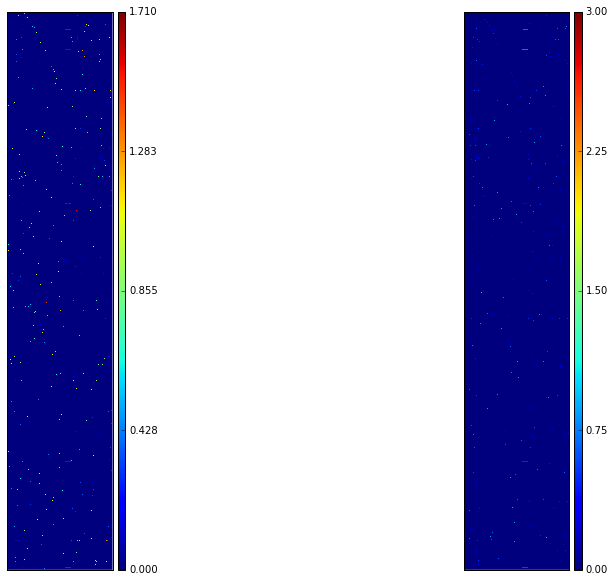

In [16]:
print models_res_all[0].keys()
plt.figure(figsize=(15,10))
plt.subplot(121)
draw_matrix(models_res_all[1]['SparseGamma']['F'])
plt.subplot(122)
draw_matrix(models_res_all[1]['BigClam-Zeros']['F'])

[ 1.  1.  1.  2.  1.  1.  1.]
24.0
[ True  True  True  True False False False]
[[3]
 [3]
 [3]
 [6]]
[[0 1 1 1]
 [1 0 1 1]
 [1 1 0 1]
 [1 1 1 0]]
[[-0.375  0.625  0.625  0.25 ]
 [ 0.625 -0.375  0.625  0.25 ]
 [ 0.625  0.625 -0.375  0.25 ]
 [ 0.25   0.25   0.25  -1.5  ]]
[[ 1.    1.    1.    0.5 ]
 [ 1.    1.    1.    0.5 ]
 [ 1.    1.    1.    0.5 ]
 [ 0.5   0.5   0.5   0.25]]
[[-0.375  0.625  0.625  0.125]
 [ 0.625 -0.375  0.625  0.125]
 [ 0.625  0.625 -0.375  0.125]
 [ 0.125  0.125  0.125 -0.375]]
[False False False  True  True  True  True]
[[6]
 [3]
 [3]
 [3]]
[[0 1 1 1]
 [1 0 1 1]
 [1 1 0 1]
 [1 1 1 0]]
[[-1.5    0.25   0.25   0.25 ]
 [ 0.25  -0.375  0.625  0.625]
 [ 0.25   0.625 -0.375  0.625]
 [ 0.25   0.625  0.625 -0.375]]
[[ 0.25  0.5   0.5   0.5 ]
 [ 0.5   1.    1.    1.  ]
 [ 0.5   1.    1.    1.  ]
 [ 0.5   1.    1.    1.  ]]
[[-0.375  0.125  0.125  0.125]
 [ 0.125 -0.375  0.625  0.625]
 [ 0.125  0.625 -0.375  0.625]
 [ 0.125  0.625  0.625 -0.375]]
0.25


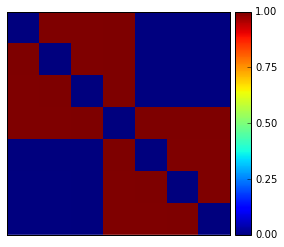

In [125]:
F = np.array([[1.,1.,1.,1.,0.,0.,0.], [0.,0.,0.,1.,1.,1.,1.]]).T
At = test_example()
draw_matrix(At)
print MixedModularity(F, At)